In [ ]:
%matplotlib inline

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=73847a3221f93a2f2797524421b9c176ed7cb9eb6dbd26ee4372f318abc1135a
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


In [ ]:
import wikipedia
import re
from bs4 import BeautifulSoup
topics = ["Cancer","Neural network","Machine learning","Healthcare","Medical imaging","Deep learning"]
texts = []
for topic in topics:
  try:
    page = wikipedia.page(topic)
    texts.append(page.content)
  except:
    pass

# Minor cleaning
text = [
    re.sub(r"\s+", " ",
        re.sub(r"\d+", "",
        re.sub(r"[^\w\s]", " ",
        BeautifulSoup(t.lower(), "html.parser").get_text()
    ))).strip()
    for t in texts
]


/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenizing all the words
tokenized = []
for t in text:
  tokenized.append(word_tokenize(t.lower()))

# Flattening
flat_tokens = []
for doc in tokenized:
  for w in doc:
    if w.isalpha():
      flat_tokens.append(w)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from collections import Counter

word_counts = Counter(flat_tokens)
vocab = []
word_to_idx = []
for w, c in word_counts.items():
  if c >= 5:
    vocab.append(w)

# For word/embedding lookup
word_to_idx = {w:i for i,w in enumerate(vocab)}
idx_to_word = {i:w for w,i in word_to_idx.items()}

print(len(vocab))


581


In [ ]:
pairs = []

# flat_tokens is the full linear sequence of all tokens in the corpus
# Example: ["the", "president", "spoke", "about", "the", "economy", ...]
# It should already contain only words in the vocabulary.

sequence = []

for w in flat_tokens:
    if w in word_to_idx:
        sequence.append(w)


# Now generate skip-gram pairs with a context window
window_size = 3

sequence_length = len(sequence)

i = 0
while i < sequence_length:

    center_word = sequence[i]
    center_index = word_to_idx[center_word]

    # compute left boundary of context window
    left_limit = i - window_size
    if left_limit < 0:
        left_limit = 0

    # compute right boundary of context window
    right_limit = i + window_size
    if right_limit >= sequence_length:
        right_limit = sequence_length - 1

    j = left_limit
    while j <= right_limit:

        # skip the center position
        if j != i:
            context_word = sequence[j]
            context_index = word_to_idx[context_word]

            pair = (center_index, context_index)
            pairs.append(pair)

        j += 1

    i += 1


In [ ]:
# Negative sampling
def neg_samples(batch_size, k=5):

    samples = []

    for _ in range(batch_size):
        row = []
        for _ in range(k):
            random_index = torch.randint(0, len(vocab), (1,)).item()
            row.append(random_index)
        samples.append(row)

    negative_tensor = torch.tensor(samples)
    return negative_tensor


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 100

class Word2VecSGNS(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        # center-word embeddings
        self.in_embed = nn.Embedding(vocab_size, embed_dim)

        # context-word embeddings
        self.out_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, center_words, target_words, negative_words):

        center = self.in_embed(center_words)              # (batch, dim)
        pos    = self.out_embed(target_words)             # (batch, dim)
        neg    = self.out_embed(negative_words)           # (batch, neg, dim)

        # dot(center, positive)
        pos_score = torch.sum(center * pos, dim=1)

        # dot(center, negative samples) using a batch matmul
        neg_score = torch.bmm(
            neg,
            center.unsqueeze(2)
        ).squeeze()

        # SGNS loss
        loss = -torch.mean(
            torch.log(torch.sigmoid(pos_score)) +
            torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1)
        )

        return loss



In [ ]:
import numpy as np

epochs = 9   # you can increase later
batch_size = 128

pairs_np = np.array(pairs)

model = Word2VecSGNS(len(vocab), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.02)

for epoch in range(epochs):
    print("EPOCH:", epoch)
    i = 0
    total_loss = 0

    while i < len(pairs_np):

        batch = []
        j = i
        batch_end = i + batch_size
        while j < batch_end and j < len(pairs_np):
            batch.append(pairs_np[j])
            j += 1

        if len(batch) == batch_size:

            center_list = []
            pos_list = []

            for pair in batch:
                center_list.append(pair[0])
                pos_list.append(pair[1])

            center_tensor = torch.tensor(center_list)
            pos_tensor = torch.tensor(pos_list)
            neg_tensor = neg_samples(batch_size)

            loss = model(center_tensor, pos_tensor, neg_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        i += batch_size

    print("  total loss =", total_loss)


EPOCH: 0
  total loss = 4805.633937120438
EPOCH: 1
  total loss = 1728.0848420858383
EPOCH: 2
  total loss = 1349.1846301555634
EPOCH: 3
  total loss = 1239.296739578247
EPOCH: 4
  total loss = 1212.9758368730545
EPOCH: 5
  total loss = 1207.2717900276184
EPOCH: 6
  total loss = 1213.4974703788757
EPOCH: 7
  total loss = 1195.5738172531128
EPOCH: 8
  total loss = 1186.1224814653397


In [ ]:
import random

window_size = 3;

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [ ]:
# Configuration
GLOVE_PATH = "glove.6B.100d.txt"
TOP_K = 50
QUERY_WORD = "laptop"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Loading Glove Vectors
def load_glove(GLOVE_PATH):
  print(f"Loading GloVe from {GLOVE_PATH} ...")
  vocab = []
  vectors = []

  with open(GLOVE_PATH, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Reading"):
      tokens = line.strip().split()
      word = tokens[0]
      vec = np.array(tokens[1:], dtype=np.float32)
      vocab.append(word)
      vectors.append(vec)

  vectors = np.stack(vectors)
  word2idx = {}
  for i, w in enumerate(vocab):
    word2idx[w] = i
  print(f"Loaded {len(vocab)} words, dim={vectors.shape[1]}")
  return vocab, word2idx, torch.from_numpy(vectors)

In [ ]:
# Normalization Function
def normalize_embeddings(emb):
  return torch.nn.functional.normalize(emb, p = 2, dim = 1)

In [ ]:
# Find Nearest Neighbors
def topk_neighbors(QUERY_WORD, emb_norm, word2idx, vocab, k = TOP_K):
  if QUERY_WORD not in word2idx:
    raise ValueError(f"'{QUERY_WORD}' not in vocabulary.")
  q_idx = word2idx[QUERY_WORD]
  q = emb_norm[q_idx]
  # Multiplying normalized versions of the embedded versions with q
  # CUDA helps to do the matrix multiplication extremely fast
  similarites = emb_norm @ q
  # Forcing query word to have lowest similarity
  similarites[q_idx] = -1e9
  vals, indexes = torch.topk(similarites, k)
  return [(vocab[int(i)], float(vals[j])) for j, i in enumerate(indexes)]



In [ ]:
# PCA Reduction
def pca_2d(X):
  X = X - X.mean(0, keepdim = True)
  U, S, V = torch.pca_lowrank(X, q = 2)
  Z = X @ V[:, :2]
  return Z

In [ ]:
# Visualization Function
def plot_words(words, Z, query_word):
  Z = Z.cpu().numpy()
  x, y = Z[:, 0], Z[:, 1]
  plt.figure(figsize=(7, 6))
  plt.scatter(x, y, s=30)
  for i, w in enumerate(words):
    plt.text(x[i] + 0.01, y[i] + 0.01, w, fontsize=9)
  qi = words.index(QUERY_WORD)
  plt.scatter([x[qi]], [y[qi]], s=120, marker = "*", c="red")
  plt.title(f"Neighborhood of '{QUERY_WORD}")
  plt.show()


In [ ]:
# Main Function Part 1 - Loading Data
#vocab, word2idx, emb = load_glove(GLOVE_PATH)
trained_embeddings = model.in_embed.weight.detach().numpy()

# Convert trained embedding matrix to a torch tensor on your DEVICE
emb = torch.tensor(model.in_embed.weight.detach().numpy(), device=DEVICE)

# Also make normalized embeddings if you use emb_norm in topk_neighbors
emb_norm = normalize_embeddings(emb)
emb = emb.to(DEVICE)
emb_norm = normalize_embeddings(emb)

Enter any word: cancer


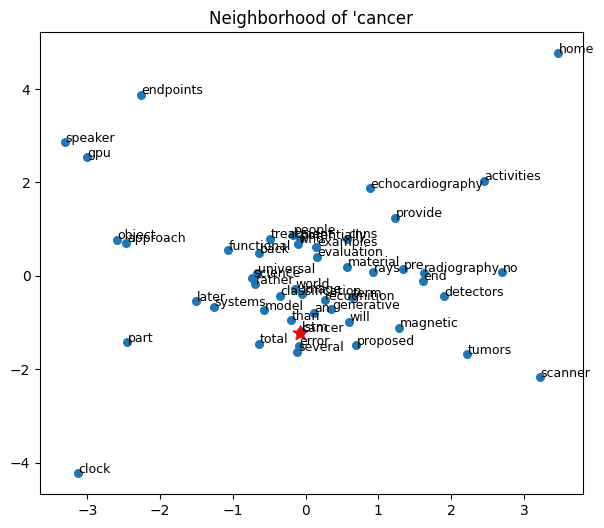


Top-50 neighbors of 'cancer':
  clock            cos=0.371
  systems          cos=0.297
  rays             cos=0.295
  recognition      cos=0.293
  home             cos=0.290
  magnetic         cos=0.274
  world            cos=0.267
  science          cos=0.260
  classification   cos=0.260
  universal        cos=0.256
  than             cos=0.255
  evaluation       cos=0.254
  scanner          cos=0.247
  several          cos=0.246
  will             cos=0.244
  an               cos=0.243
  who              cos=0.239
  model            cos=0.236
  generative       cos=0.231
  radiography      cos=0.228
  no               cos=0.227
  detectors        cos=0.224
  tumors           cos=0.223
  functional       cos=0.221
  end              cos=0.217
  image            cos=0.216
  gpu              cos=0.213
  examples         cos=0.209
  proposed         cos=0.207
  total            cos=0.206
  treatment        cos=0.204
  echocardiography  cos=0.204
  lstm             cos=0.202
  object   

In [ ]:
# Main Function Part 2

# Getting input
QUERY_WORD = input("Enter any word: ")

# Gets all neighbors of query word
neighbors = topk_neighbors(QUERY_WORD, emb_norm, word_to_idx, vocab, TOP_K)

# Collecting subset for plotting(creates smaller tensor for PCA visualization)
words = [QUERY_WORD] + [w for w, _ in neighbors]
idxs = torch.tensor([word_to_idx[w] for w in words], device=DEVICE)
X = emb[idxs]

# Plotting
Z = pca_2d(X)
plot_words(words, Z, QUERY_WORD)

# Printing the top 40 and their similiarity values
print(f"\nTop-{TOP_K} neighbors of '{QUERY_WORD}':")
for w, s in neighbors:
    print(f"  {w:15s}  cos={s:.3f}")

